## Description
---
This notebook is for the comparison of HYCOM and *in situ* ACT mooring array sections. For the ACT experiment period, only a gridded velocity section is available. A gridded section of velocity, temperature and salinity is available for the ASCA experiment duration and their means might make a useful comparison against the model runs here.

- The ACT data can be accessed here:
https://beal-agulhas.earth.miami.edu/data-and-products/index.html
Specifically, the ACT *in situ* velocity section data is used:
https://drive.google.com/file/d/112LWQ2Mvtmz-1xFNuySS3kHdmFCHqCAz/view?usp=sharing
- Positive cross-track velocities point approximately toward the northeast (64 deg), and  negative velocities point toward the southwest (244 deg).

If this data is used in a publication, a requested reference as per the website is to be used:
*'Gridded cross-sectional velocities are based on in situ current meter measurements from the Agulhas Current Time-series (ACT) experiment (Beal et al., 2015) and can be downloaded at https://beal-agulhas.rsmas.miami.edu/data-and-products/index.html.'*

- For the HYCOM data, a the m2section routine was used with the following coordinates for the section, as per the sections.in file:

`ACT_ARRAY
28.90  -35.70
27.49 -33.29`
- From the HYCOM NERSC manual:
'*The positive directions of a section can be found by the following rule. When
standing at the first point of a section, and looking towards the next point of the section, then the positive
direction is towards your right-hand side.*'

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import matplotlib.pyplot as plt
import cmocean.cm as cmo

In [7]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

## Import data

In [3]:
# Import ACT mooring data
ACT = xr.open_dataset('../Data/ACT_array/Section/ACT_2010-2013_full_gridded_ts_extended.nc')
ACT = ACT.sel(time=slice('2010-04-17', '2012-04-11'))
ACT['distance'] = ACT['distance'].values / 1000 # Convert from m to km

# Import HYCOM ACT section data
FREE = xr.open_dataset('../Data/ACT_array/Section/FREE_section.nc')
# FREE['distance'] = FREE['distance'] / 1000 # Convert from m to km
CCI = xr.open_dataset('../Data/ACT_array/Section/CCI_section.nc')
# CCI['distance'] = CCI['distance'] / 1000 # Convert from m to km
OSTIA = xr.open_dataset('../Data/ACT_array/Section/OSTIA_section.nc')
# OSTIA['distance'] = OSTIA['distance'] / 1000 # Convert from m to km

for hycom in [FREE, CCI, OSTIA]:
    hycom['distance'] = np.flip(hycom['distance']) / 1000 # Convert from m to km
#     np.flip(FREE['distance'])

## Rotate HYCOM velocities
---
Here we need to rotate HYCOM velocities to the normal in order to match the format that the ACT data is in. This could be done by first getting the vector and magnitude and then decomposing into components or it could be done by vector rotation. I will first attempt the second option as I have already tried to do this for the HYCOM m2section routine in Fortran. I recall it working fairly well. I can try make a test example here.

---

Firstly, the angle between starting and ending points needs to be determined. This can be done given starting and ending coordinates of the HYCOM section.in file and the method proposed in this StackOverflow answer:
https://stackoverflow.com/a/72602196

Secondly, the process of rotating the vectors is as described here:
https://www.mathworks.com/help/phased/ref/rotz.html

### Full rotation code
This is taking all the rotation work and fitting it into a single function

In [4]:
def RotateHYCOMvelocities(dataset, lon_1, lat_1, lon_2, lat_2):
    '''Rotate HYCOM [dataset] velocity vectors to normal (along section) using start
    [lon_1, lat_1] and end [lon_2, lat_2] points of the section.
    
    First, the bearing of the section will be determined.  This bearing will then
    be used to create the rotation matrix used to rotate the velocity vector pairs.
    
    The rotated dataset is returned.
    
    Usage: datasetRotated = RotateHYCOMvelocities(dataset, rotMatrix)
    '''
    # Find section bearing (gamma)
    print('Finding bearing...', end = "")
    y = np.log(np.tan(np.pi / 4 + np.radians(lat_2) / 2) / 
               np.tan(np.pi / 4 + np.radians(lat_1) / 2))
    x = np.radians(lon_2 - lon_1)
    gamma = np.arctan2(x, y)
    print('done.')
    
    # Create the rotation matrix (R) for gamma
    print('Creating rotation matrix ...', end = "")
    R = Rot.from_rotvec(gamma * np.array([0, 0, 1])) # Scipy function
    print('done.')
    
    # Create new array with both u & v vectors
    hycom = dataset.copy() # Without .copy(), dataset will be changed in-place
    vecArray = np.array([hycom['east_utot'], hycom['north_vtot']])
    print('Now rotating HYCOM velocities...', end = "")
    # Loop through all dimensions and rotate each u & v pair
    for i in np.arange(0, vecArray.shape[1]):
        for j in np.arange(0, vecArray.shape[2]):
            for k in np.arange(0, vecArray.shape[3]):
                rotated_vecs = R.apply([vecArray[0, i, j, k], vecArray[1, i, j, k], 0])
                vecArray[0, i, j, k] = rotated_vecs[0]
                vecArray[1, i, j, k] = rotated_vecs[1]
    # Assigning rotated vectors to dataset after completion is much faster
    hycom['east_utot'].data = vecArray[0, :, :, :]
    hycom['north_vtot'].data = vecArray[1, :, :, :]
    print('done. Vectors rotated.')
    return hycom

In [5]:
start_lon = 28.90
start_lat = -35.70
end_lon = 27.49
end_lat = -33.29

FREE_rot = RotateHYCOMvelocities(FREE, start_lon, start_lat, end_lon, end_lat)
OSTIA_rot = RotateHYCOMvelocities(OSTIA, start_lon, start_lat, end_lon, end_lat)
CCI_rot = RotateHYCOMvelocities(CCI, start_lon, start_lat, end_lon, end_lat)

Finding bearing...done.
Creating rotation matrix ...done.
Now rotating HYCOM velocities...done. Vectors rotated.
Finding bearing...done.
Creating rotation matrix ...done.
Now rotating HYCOM velocities...done. Vectors rotated.
Finding bearing...done.
Creating rotation matrix ...done.
Now rotating HYCOM velocities...done. Vectors rotated.


## Plot velocity

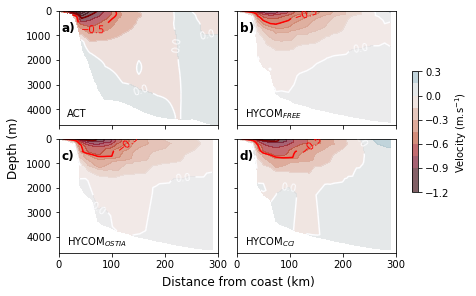

In [46]:
simulations = [FREE_rot, OSTIA_rot, CCI_rot]
fig, axs = plt.subplots(2, 2, figsize = (6.5, 4), constrained_layout = True, sharex = True,
                       sharey = True)

# Get cmap and set NaN values to grey colour
cmap = plt.cm.get_cmap("seismic_r").copy()
cmap.set_bad('grey', alpha = 0.4)

axs[0,0].contourf(ACT['distance'], ACT['depth'], ACT['v'].mean(dim = 'time').transpose(),
                  11, vmin = -1.0, vmax = 1.0, cmap = cmo.balance_r, alpha = 0.65)
CS = axs[0,0].contour(ACT['distance'], ACT['depth'], ACT['v'].mean(dim = 'time').transpose(),
                      np.arange(-1,1.5,0.5), vmin = -1.0, vmax = 1.0, cmap = 'seismic_r',
                      alpha = 1)
axs[0,0].clabel(CS, np.arange(-0.5,1.5,0.5), inline = True)

# Only call axis inversion once, otherwise loop will revert flipping (3 x flips in loop)
axs[0,0].invert_yaxis()

for i, ax in enumerate(axs.flatten()[1:]):
    img = ax.contourf(np.tile(simulations[i]['distance'], (30, 1)),
                simulations[i]['intf_lower'].mean(dim = 'time'),
                simulations[i]['east_utot'].mean(dim = 'time'), 11,
                vmin = -1.0, vmax = 1.0, cmap = cmo.balance_r, alpha = 0.65)
    CS = ax.contour(np.tile(simulations[i]['distance'], (30, 1)),
                    simulations[i]['intf_lower'].mean(dim = 'time'),
                    simulations[i]['east_utot'].mean(dim = 'time'), np.arange(-1, 1.5, 0.5),
                    vmin = -1.0, vmax = 1.0, cmap = 'seismic_r', alpha = 1)
    ax.clabel(CS, np.arange(-0.5,1.5,0.5), inline = True)

# Add subplot labels
for subp_no, ax in enumerate(axs.flatten()):
    subp_label = chr(ord('a') + subp_no)
    subp_DatasetName = ['ACT', 'HYCOM$_{FREE}$', 'HYCOM$_{OSTIA}$', 'HYCOM$_{CCI}$'][subp_no]
    ax.text(0.02, 0.85, f'{subp_label})', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes,
            fontsize='large', fontweight='semibold')
    ax.text(0.05, 0.1, f'{subp_DatasetName}', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes,
            fontsize='medium', fontweight='regular')

fig.supxlabel('Distance from coast (km)')
fig.supylabel('Depth (m)')
cbar = plt.colorbar(img, ax=axs[:], location='right', shrink=0.5, extend='both',
                    pad=0.02)
cbar.set_label('Velocity (m.s$^{\minus1}$)')

save_dir = '../Figures/act'
fig_name = 'HYCOM_ACT_velocityMean.png'
plt.savefig(f'{save_dir}/{fig_name}', dpi=300, bbox_inches='tight', format='png')

## Plot temperature, salinity, density

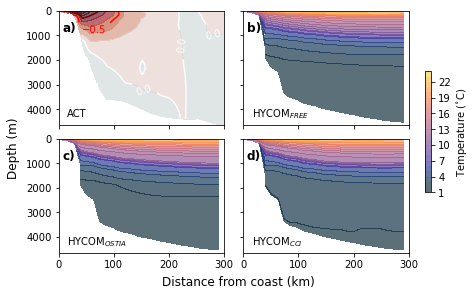

In [57]:
simulations = [FREE_rot, OSTIA_rot, CCI_rot]
fig, axs = plt.subplots(2, 2, figsize = (6.5, 4), constrained_layout = True, sharex = True,
                       sharey = True)

axs[0,0].contourf(ACT['distance'], ACT['depth'], ACT['v'].mean(dim = 'time').transpose(),
                  11, vmin = -1.0, vmax = 1.0, cmap = cmo.balance_r, alpha = 0.65)
CS = axs[0,0].contour(ACT['distance'], ACT['depth'], ACT['v'].mean(dim = 'time').transpose(),
                      np.arange(-1,1.5,0.5), vmin = -1.0, vmax = 1.0, cmap = 'seismic_r',
                      alpha = 1)
axs[0,0].clabel(CS, np.arange(-0.5,1.5,0.5), inline = True)

# Only call axis inversion once, otherwise loop will revert flipping (3 x flips in loop)
axs[0,0].invert_yaxis()

for i, ax in enumerate(axs.flatten()[1:]):
    img = ax.contourf(np.tile(simulations[i]['distance'], (30, 1)),
                simulations[i]['intf_lower'].mean(dim = 'time'),
                simulations[i]['temp'].mean(dim = 'time'), 24,
                vmin = 2, vmax = 26, cmap = cmo.thermal, alpha = 0.65)
#     img = ax.pcolormesh(np.tile(simulations[i]['distance'], (30, 1)),
#                 simulations[i]['intf_lower'].mean(dim = 'time'),
#                 simulations[i]['temp'].mean(dim = 'time'),
#                 vmin = 0, vmax = 30, cmap = cmo.thermal, alpha = 0.65)
#     CS = ax.contour(np.tile(simulations[i]['distance'], (30, 1)),
#                     simulations[i]['intf_lower'].mean(dim = 'time'),
#                     simulations[i]['temp'].mean(dim = 'time'), np.arange(-1, 1.5, 0.5),
#                     vmin = 0, vmax = 30, cmap = , alpha = 1)
#     ax.clabel(CS, np.arange(-0.5,1.5,0.5), inline = True)

# Add subplot labels
for subp_no, ax in enumerate(axs.flatten()):
    subp_label = chr(ord('a') + subp_no)
    subp_DatasetName = ['ACT', 'HYCOM$_{FREE}$', 'HYCOM$_{OSTIA}$', 'HYCOM$_{CCI}$'][subp_no]
    ax.text(0.02, 0.85, f'{subp_label})', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes,
            fontsize='large', fontweight='semibold')
    ax.text(0.05, 0.1, f'{subp_DatasetName}', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes,
            fontsize='medium', fontweight='regular')

fig.supxlabel('Distance from coast (km)')
fig.supylabel('Depth (m)')
cbar = plt.colorbar(img, ax=axs[:], location='right', shrink=0.5, extend='both',
                    pad=0.02)
cbar.set_label('Temperature ($^{\circ}$C)')

save_dir = '../Figures/act'
fig_name = 'HYCOM_ACT_temperatureMean.png'
plt.savefig(f'{save_dir}/{fig_name}', dpi=300, bbox_inches='tight', format='png')

In [68]:
def plot_TempSection(datasets):
    '''Plot vertical sections of HYCOM along ACT transect.
    
    This function will plot 3 plots. First, temperature sections for each dataset.
    Secondly, salinity and lastly, density.
    
    e.g. usage: plot_TempSection(datasets)
    '''
    # Temperature
    fig, axs = plt.subplots(3,1, figsize = (3,5), constrained_layout=True)
    for i,ax in enumerate(axs):
#         ax.plot(datasets[i]['temp'].mean())
#         ax.pcolormesh(datasets[i][0]['temp'].mean(dim='time', skipna=True))
#         ax.pcolormesh(datasets[i][0]['distance'], datasets[i][0]['depth'],
#                       datasets[i][0]['temp'].mean(dim='time', skipna=True).transpose()) # doesn't work
        ax.contour(datasets[i][0]['pres'].mean(dim='time', skipna=True), 30)
        ax.invert_yaxis()
        ax.invert_xaxis()


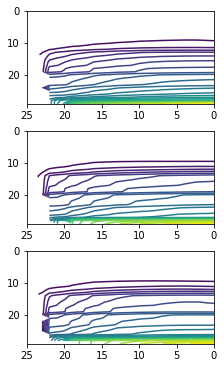

In [69]:
plot_TempSection([(FREE, 'FREE'), (OSTIA, 'OSTIA'), (CCI, 'CCI')])

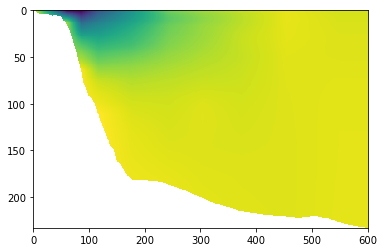

In [25]:
# FREE['temp'].mean(dim='time').plot()
# FREE['temp'].mean(dim='time').transpose()
# plt.pcolormesh(FREE['distance'], FREE['depth'], FREE['temp'].mean(dim='time').transpose())
# FREE['depth'] = -FREE['depth']
plt.pcolormesh(ACT['v'].mean(dim='time').transpose())
# plt.contour(FREE['temp'].mean(dim='time'))
ax = plt.gca()
ax.invert_yaxis()
# ax.invert_xaxis()
# plt.pcolormesh(FREE['temp'].mean(dim='time').transpose())
# FREE['distance'].shape

In [50]:
ACT

<xarray.Dataset>
Dimensions:   (depth: 233, distance: 601, time: 1451)
Coordinates:
  * depth     (depth) float64 0.0 20.0 40.0 60.0 ... 4.6e+03 4.62e+03 4.64e+03
  * distance  (distance) float64 0.0 500.0 1e+03 ... 2.99e+05 2.995e+05 3e+05
  * time      (time) datetime64[ns] 2010-04-17T12:00:00 ... 2012-04-11T12:00:00
Data variables:
    v         (time, distance, depth) float64 ...
Attributes: (12/15)
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    title:                  ACT array cross track velocity
    Conventions:            CF-1.6, ACDD-1.3
    processing_level:       Current meter and CPIES velocity data were linear...
    acknowledgement:        The Agulhas Current Time-series experiment is fun...
    references:             Beal L. M., S. Elipot, A. Houk and G. M. Leber, (...
    ...                     ...
    institution:            University of Miami
    project:                Agulhas Current Time-series experiment (ACT)
    time_coverage_start:    2010-04-17T12:00:00Z
    time_coverage_end:      2013-02-19T00:00:00Z
    product version:        1.0
    sea name:               Indian Ocean

AttributeError: 'DataArray' object has no attribute 'contour'

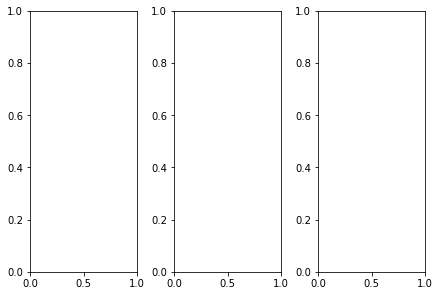

In [32]:
plot_TempSection([FREE,OSTIA,CCI])

In [54]:
FREE['temp'].mean(dim='time').plot()
# FREE['temp'].swap_dims({'depth': 'distance'})

ValueError: ('distance', 'distance') must be a permuted list of ('depth', 'distance'), unless `...` is included

In [44]:
FREE

<xarray.Dataset>
Dimensions:     (time: 726, distance: 26, depth: 30)
Coordinates:
  * time        (time) float32 2.01e+03 2.01e+03 ... 2.012e+03 2.012e+03
  * distance    (distance) float32 7.071e+03 1.756e+04 ... 2.795e+05 2.898e+05
    depth       (distance) float32 4.522e+03 4.507e+03 4.481e+03 ... 98.99 72.61
Data variables:
    lon         (distance) float32 28.92 28.91 28.77 28.75 ... 27.64 27.62 27.61
    lat         (distance) float32 -35.64 -35.54 -35.46 ... -33.51 -33.42 -33.32
    intf_lower  (time, depth, distance) float32 ...
    saln        (time, depth, distance) float32 ...
    temp        (time, depth, distance) float32 25.04 25.03 25.05 ... nan nan
    pres        (time, depth, distance) float32 ...
    east_utot   (time, depth, distance) float32 ...
    north_vtot  (time, depth, distance) float32 ...
Attributes:
    sectionname:  ACT_ARRAY

In [19]:
ACT = xr.open_dataset('../Data/ACT_array/Transport/ACTtransport_insitu.nc')
ACT

<xarray.Dataset>
Dimensions:  (time: 2078)
Coordinates:
  * time     (time) datetime64[ns] 2010-04-17T12:00:00 2010-04-18 ... 2013-02-19
Data variables:
    Tbox     (time) float32 ...
    Tjet     (time) float32 ...
Attributes: (12/17)
    featureType:          timeSeries
    title:                Agulhas Current boundary and jet transports from in...
    summary:              see methodology in Beal L. M., S. Elipot, A. Houk a...
    history:              original and first version
    acknowledgement:      The Agulhas Current Time-series experiment is funde...
    references:           Beal L. M., S. Elipot, A. Houk and G. M. Leber, (20...
    ...                   ...
    publisher_name:       Shane Elipot
    publisher_email:      selipot@rsmas.miami.edu
    time_coverage_start:  2010-04-17T12:00:00Z
    time_coverage_end:    2010-04-17T12:00:00Z
    product version:      1.0
    sea name:             Indian Ocean

In [37]:
cci

<xarray.Dataset>
Dimensions:           (N_2: 2, section: 1, time: 723)
Coordinates:
  * time              (time) datetime64[ns] 2010-04-17T12:00:00 ... 2012-04-08T12:00:00
Dimensions without coordinates: N_2, section
Data variables:
    sectionname       (section) |S20 ...
    section_lon       (section, N_2) float32 ...
    section_lat       (section, N_2) float32 ...
    transport         (time, section) float32 ...
    transport_neg     (time, section) float32 ...
    transport_pos     (time, section) float32 ...
    icetransport      (time, section) float32 ...
    icetransport_neg  (time, section) float32 ...
    icetransport_pos  (time, section) float32 ...
Attributes:
    title:        TOPAZ transport across sections
    institution:  NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    references:   http://topaz.nersc.no
    comment:      Transports are defined as positive if it is towards the rig...

In [7]:
HYCOMcci.where(HYCOMcci.transport==HYCOMcci.transport.max(), drop=True).squeeze()

<xarray.Dataset>
Dimensions:           (N_2: 2)
Coordinates:
    time              datetime64[ns] 2011-09-28T12:00:00
Dimensions without coordinates: N_2
Data variables:
    sectionname       object b'ACT_ARRAY           '
    section_lon       (N_2) float32 27.76488 28.905796
    section_lat       (N_2) float32 -33.59943 -35.54219
    transport         float32 238.82446
    transport_neg     float32 -0.9523389
    transport_pos     float32 239.7768
    icetransport      float32 0.0
    icetransport_neg  float32 0.0
    icetransport_pos  float32 0.0
Attributes:
    title:        TOPAZ transport across sections
    institution:  NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    references:   http://topaz.nersc.no
    comment:      Transports are defined as positive if it is towards the rig...

In [8]:
HYCOMcci.where(HYCOMcci.transport==HYCOMcci.transport.min(), drop=True).squeeze()

<xarray.Dataset>
Dimensions:           (N_2: 2)
Coordinates:
    time              datetime64[ns] 2011-07-03T12:00:00
Dimensions without coordinates: N_2
Data variables:
    sectionname       object b'ACT_ARRAY           '
    section_lon       (N_2) float32 27.76488 28.905796
    section_lat       (N_2) float32 -33.59943 -35.54219
    transport         float32 -67.48152
    transport_neg     float32 -109.96445
    transport_pos     float32 42.482925
    icetransport      float32 0.0
    icetransport_neg  float32 0.0
    icetransport_pos  float32 0.0
Attributes:
    title:        TOPAZ transport across sections
    institution:  NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    references:   http://topaz.nersc.no
    comment:      Transports are defined as positive if it is towards the rig...

In [ ]:
# read SST datasets
